<h1>Load Data</h1>

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
from pathlib import Path
import itertools
import os
import shutil
import random
import glob
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline

random.seed(42)

#Organize data into train, test and validation sets
notebook_dir = Path.cwd() #get current notebook dir

data_folder = notebook_dir.parent / "data" #create path to data folder

os.chdir(data_folder)

#create folders inside data
dirs = [
    "train/dog", "train/cat",
    "valid/dog", "valid/cat",
    "test/dog",  "test/cat"
]

for d in dirs:
    (data_folder / d).mkdir(parents=True, exist_ok=True)


#Base folders
target_folders = ["train", "valid", "test"]

#Create target folders if they don't exist
for split in target_folders:
    for cls in ["cat", "dog"]:
        folder = data_folder / split / cls
        folder.mkdir(parents=True, exist_ok=True)

#Source folders
cat_src = data_folder / "Cat"
dog_src = data_folder / "Dog"

#Function to move images randomly
def move_images(src_folder, dst_folder, n):
    imgs = list(src_folder.glob("*.jpg"))
    sampled = random.sample(imgs, n)
    for img_path in sampled:
        shutil.move(str(img_path), dst_folder)

#Move images
move_images(cat_src, data_folder / "train" / "cat", 500)
move_images(dog_src, data_folder / "train" / "dog", 500)
move_images(cat_src, data_folder / "valid" / "cat", 100)
move_images(dog_src, data_folder / "valid" / "dog", 100)
move_images(cat_src, data_folder / "test" / "cat", 100)
move_images(dog_src, data_folder / "test" / "dog", 100)

Images moved successfully!


<h3>Look at some images of the dataset</h3>

In [ ]:
import pandas as pd
from PIL import Image
import imagesize

root = "../data/"

imgs = [img for img in Path(root).rglob("*.jpg")] #get all images from the subfolders

sampled = random.sample(imgs, 6)

plt.figure(figsize=(12, 8)) 
for i, filename in enumerate(sampled, 1):
     img_path = Path(root) / filename 
     img = Image.open(img_path) 
     plt.subplot(2, 3, i) 
     plt.imshow(img) 
     plt.axis("off") 
     plt.title(img_path.name) 
plt.tight_layout() 
plt.show()

Visualizing image sizes
<p>Before we resize the images we check out the datasets qualities.
<ul>
    <li>Size</li>
    <li>Width</li>
    <li>Height</li>
</ul>


In [ ]:
img_meta = {}
for f in imgs: 
    img_meta[str(f)] = imagesize.get(f)  #Here we get the images resolution (f represents one image it is a path object)

#Convert into dataframe
img_meta_df = pd.DataFrame.from_dict([img_meta]).T.reset_index().set_axis(['FileName', 'Size'], axis='columns')
img_meta_df[["Width", "Height"]] = pd.DataFrame(img_meta_df["Size"].tolist(), index=img_meta_df.index)
img_meta_df["Aspect Ratio"] = round(img_meta_df["Width"] / img_meta_df["Height"], 2)

print(f'Total Nr of Images in the dataset: {len(img_meta_df)}')
img_meta_df.head()

#This took me ~2-3min (over all 25000 images)

Total Nr of Images in the dataset: 23387


,FileName,Size,Width,Height,Aspect Ratio
0,..\data\Cat\0.jpg,"(500, 375)",500,375,1.33
1,..\data\Cat\1.jpg,"(300, 281)",300,281,1.07
2,..\data\Cat\10.jpg,"(489, 500)",489,500,0.98
3,..\data\Cat\100.jpg,"(403, 500)",403,500,0.81
4,..\data\Cat\1000.jpg,"(150, 150)",150,150,1.00


Text(0, 0.5, 'Height')

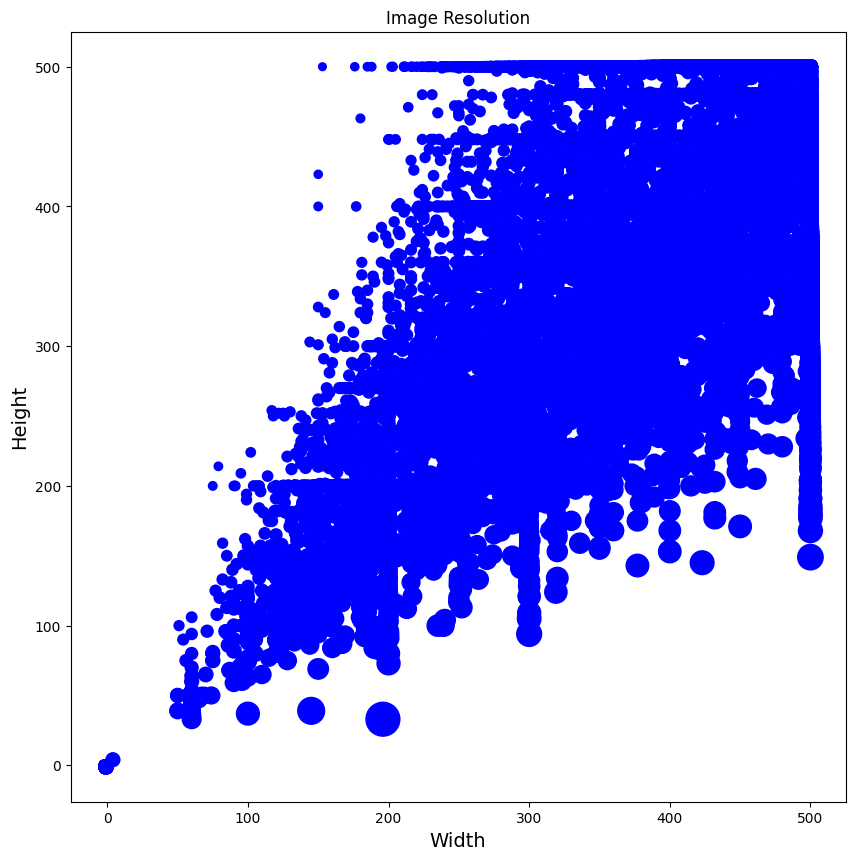

In [43]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
points = ax.scatter(img_meta_df.Width, img_meta_df.Height, color='blue', s=img_meta_df["Aspect Ratio"]*100, picker=True)
ax.set_title("Image Resolution")
ax.set_xlabel("Width", size=14)
ax.set_ylabel("Height", size=14)